### Apresentação

Este arquivo faz a classificação de malware utilizando *multi-view* e seleção de características multi-objetivo. O resultado final deste *notebook* mostra os resultados utilizados no artigo.

### Inicialização

Inicializa todas as bibliotecas utilizadas neste notebook.

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

import numpy as np
import pickle
from time import time
import os
import sys

from sklearn.metrics import (f1_score)
from sklearn.ensemble import RandomForestClassifier
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling

In [10]:
def LoadFeaturesClassApicallsPCA():
    return (np.load(open("../../npy/apicalls-x-pca-ordered.npy","rb"))
            , np.load(open("../../npy/apicalls-y-full-ordered.npy","rb")))

def LoadFeaturesClassOpcodesPCA():
    return (np.load(open("../../npy/opcodes-x-pca-ordered.npy","rb"))
            , np.load(open("../../npy/opcodes-y-full-ordered.npy","rb")))

def LoadFeaturesClassPermsPCA():
    return (np.load(open("../../npy/perm-x-pca-ordered.npy","rb"))
            , np.load(open("../../npy/perm-y-full-ordered.npy","rb")))

definição do problema utilizado pelo NSGA2. O objetivo do problema é reduzir o tempo de inferência do classificador e aumentar a acurácia, selecionando a combinação ideal de características para atingir esse objeto.

In [11]:
def Minimize(problem):

    # pop_size=100 e 'n_gen'= 100. Isso define que o algoritmo fornecerá variações das variáveis por 100 gerações, e cada geração com 100 populações.
    return minimize(problem,
               NSGA2(pop_size=100, sampling=FloatRandomSampling()),
               seed=42,
               save_history=True,
               verbose=True,
               termination=('n_gen', 100))

class MyProblem(ElementwiseProblem):


    def IsToDeleteFeature(self,feature_value):
        return feature_value < 0.5
    
    def GetPredictedClassification(self, features, y):

        x_train, x_test, y_train, y_test = train_test_split(features
                                                            , y
                                                            , train_size=0.7
                                                            , random_state=42)
        
        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
        model.fit(X=x_train, y=y_train)

        t0 = time()
        y_test_predict = model.predict(x_test)
        t1 = (time() - t0)

        return y_test_predict,y_test, t1

    def EvaluateModelErrorTime(self, features_apicalls_tmp, features_opcodes_tmp, features_perms_tmp, y):

        y_voting = []
        y_test_predict_apicalls, y_test_true, t1_apicalls = self.GetPredictedClassification(features_apicalls_tmp, y)
        y_test_predict_opcodes, y_test_true, t1_opcodes = self.GetPredictedClassification(features_opcodes_tmp, y)
        y_test_predict_perms, y_test_true, t1_perms = self.GetPredictedClassification(features_perms_tmp, y)

        # algoritmo de votação por voto majoritário.
        # a partir de cada classificação de cada view, gera-se um novo vetor de predição baseado na maioria.
        # por exemplo:
        # Se as views apicalls, opcodes, e permissões inferirem um malware, o voto será malware;
        # Se duas das views inferirem um malware, o voto será malware;
        # Se apenas uma view inferir um malware, o voto será goodware;
        for index, _ in enumerate(y_test_predict_apicalls):
            total_voting = y_test_predict_apicalls[index] + y_test_predict_opcodes[index] + y_test_predict_perms[index]
            y_voting.append(0 if total_voting < 2 else 1)


        f1_test = f1_score(y_true=y_test_true, y_pred=y_voting)

        return (1 - f1_test, t1_apicalls + t1_opcodes + t1_perms) #+ t1_voting

    def AdjustFeatures(self, x, features):
        for i in range(len(x) -1, 0 , -1):
            if self.IsToDeleteFeature(x[i]):
                features = np.delete(features, i, 1)

        return features


    def __init__(self, *args):

        self.features_apicalls = args[0]
        self.features_opcodes = args[1]
        self.features_perms = args[2]
        self.y = args[3]

        # define que o problema tem dois objetivos e utiliza uma matriz de 300 variáveis.
        # em cada população uma nova variação da matriz é fornecida.
        super().__init__(n_var=300,
                         n_obj=2,
                         xl=np.zeros(300),
                         xu=np.ones(300))
        
    # x = matriz com as variáveis definidas pelo algoritmo NSGA2.
    # out = retorna o resultado dos objetivos [acurácia e tempo].
    def _evaluate(self, x, out, *args, **kwargs):

        features_apicalls_tmp = self.features_apicalls
        features_opcodes_tmp = self.features_opcodes
        features_perms_tmp = self.features_perms

        # a matriz fornecida serve de referência para manter ou excluir uma feature da matriz de características para cada view.
        # x[0:100] - referência para a view apicalls;
        # x[100:200] - referência para a view opcodes;
        # x[200:300] - referência para a view permissões;
        # Por exemplo: 
        # se x[10] < 0.5, então a feature 9 da view api calls será removida;
        # se x[150] < 0.5, então a feature 49 da view opcode será removida;
        # se x[300] < 0.5, então a feature 99 da view permissões será removida;
        # Sempre que o valor de x[] for >= 0.5, a feature será mantida.
        features_apicalls_tmp = self.AdjustFeatures(x[0:100], features_apicalls_tmp)
        features_opcodes_tmp = self.AdjustFeatures( x[100:200], features_opcodes_tmp)
        features_perms_tmp = self.AdjustFeatures(x[200:300], features_perms_tmp)

        # faz a classificação utilizando as views com seleção de features.
        f1, f2 = self.EvaluateModelErrorTime(features_apicalls_tmp, features_opcodes_tmp, features_perms_tmp, self.y)

        # f1 = acurácia
        # f2 = tempo de inferência
        out["F"] = [f1, f2]

In [12]:
features_apicalls, y_api = LoadFeaturesClassApicallsPCA()
features_opcodes, y_op = LoadFeaturesClassOpcodesPCA()
features_perm, y_perm = LoadFeaturesClassPermsPCA()

### Processa NSGA2

In [13]:
problem = MyProblem(features_apicalls, features_opcodes, features_perm, y_op)

In [14]:
# em virtude da inviabilidade de processar o algoritmo NSGA2 por conta do tempo, a chamada do método Minimize() está comentada.
# para viabilizar essa etapa, utiliza-se um dump do resultado do Minimize()

# res = Minimize(problem)
#res = pickle.load(open("../../dumps/nsga2-maj-vot-rf.pkl", "rb"))

file_path = "../../dumps/nsga2-maj-vot-rf.pkl"

if os.path.exists(file_path):
    res = pickle.load(open(file_path, "rb"))
else:
    print(f"O arquivo {file_path} não existe no diretório esperado. \nLeia o arquivo README, seção Download de arquivos.")
    sys.exit("Interrompendo a execução do notebook.")

### Resultado

In [15]:
# ordena o resultado pela acurácia.
res_sorted = res.F[res.F[:, 1].argsort()]

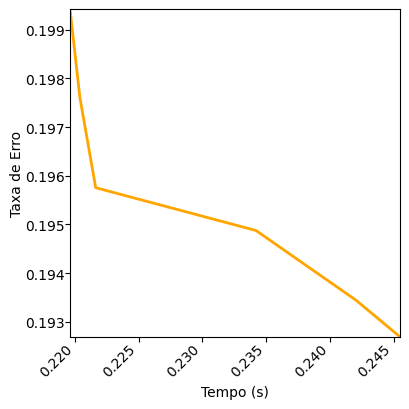

In [16]:
plt.figure(figsize=(4.2, 4.2))

plt.plot(res_sorted[:, 1], res_sorted[:, 0], color='orange', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.autoscale(tight=True)

plt.xlabel("Tempo (s)")
plt.ylabel("Taxa de Erro", labelpad=1)
plt.tick_params(axis='both', which='major', pad=0) 

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()